Описание проекта

# 1. Загрузка данных

In [1]:
pip install seaborn==0.11.0

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 283 kB 838 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans


## Загрузим датасет и приведем наименования столбцов к единому формату.

In [2]:
visitors = pd.read_csv('./datasets/gym_churn.csv')

In [3]:
visitors = visitors.rename(columns={'Near_Location': 'near_location', 
                   'Partner': 'partner', 
                   'Promo_friends': 'promo_friends', 
                   'Phone': 'phone', 
                   'Contract_period': 'contract_period', 
                   'Group_visits': 'group_visits', 
                   'Age': 'age', 
                   'Avg_additional_charges_total': 'avg_additional_charges_total', 
                   'Month_to_end_contract': 'month_to_end_contract', 
                   'Lifetime': 'lifetime',
                   'Avg_class_frequency_total': 'avg_class_frequency_total', 
                   'Avg_class_frequency_current_month': 'avg_class_frequency_current_month',
                   'Churn': 'churn'})

In [4]:
visitors.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


# 2. Исследовательский анализ данных (EDA)

In [5]:
churn_visitors = visitors.query('churn == 1')
active_visitors = visitors.query('churn == 0')

In [6]:
def print_histplot(features):
    '''
    Функция выводит гистограмму для кадого критерия из таблицы отдельно по оттоку и по активным.
    '''
    for feature in features:
        
        fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
        
        
        sns.histplot(data=churn_visitors, x=feature, color='#fc8d62', ax=ax2);
        ax2.set_title('churn')

        sns.histplot(data=active_visitors, x=feature, color='#66c2a5', ax=ax1);
        ax1.set_title('active')

        plt.show()

In [7]:
def print_prc(features):
    '''
    Функция выводит относительную величину каждого признака по оттоку и по активным'''
    sns.set_palette("Set2")
    for feature in features:
        new = visitors.groupby(by=['churn', feature]).agg({feature: 'count'})
        new = new.rename(columns={feature: 'abs'})
        new = new.reset_index()

        new['prc'] = new.apply(lambda x: new[new['churn'] == x['churn']]['abs'].sum(), axis=1)
        new['prc'] = (new['abs']/new['prc']).round(2)

        sns.barplot(x=feature, y="prc", hue="churn", data=new)
        plt.show()

## Выведем описание для всех столбцов таблицы
В таблице отсутствуют пропущенные значения, что говорит о хорошем качестве данных.
Рассмотрим все столбцы таблицы.

- `gender` - 	среди оттока и среди активных клиентов приблизительно равное количество мужчин и женщин.

- `near_location`	- среди клиентов в целом больше тех, кто живет или работает поблизости. Для посетителей, которые живут далеко, выше вероятность попасть в отток.

- `partner` - среди клиентов в целом около 50% посетителей - сотрудники компаниий-партнеров. Доля партнеров среди оттока ниже. С посетителями из компаний-партнеров более крепкие отношения.

- `promo_friends`	- около 30% посетителей приходят по акции "Приведи друга", доля оттока среди таких посетителей нииже. Посетители, приишедшие по рекомендации друзей более лояльны и реже уходят.

- `phone`	- телефон указан почти у 90% посетителей. Количество активных и отвалившихся клиентов среди них почти равное.

- `contract_period` - 1/2 посетителей клуба имеют абонементы на 1 месяц - среди них самая высокая доля оттока, 3/4 посетителей покупают абонементы сроком до 6 месяцев - они на втором месте по доле оттока. Самый низкй показатель оттока среди покупателей годового абонемента.

- `group_visits` - среди тех, кто посещает групповые тренировки доля оттока ниже.

- `age` - доля оттока выше среди посетиителей от 25 до 29, от 26 до 34 - преимущественно активные посетители.

- `avg_additional_charges_total` - средняя сумма доп. услуг 147 у.е, половина посетителей тратит до 210 у.е. У активных посетителей средняя сумма доп.услуг составляет 100-200, у оттока - 50-100.

- `month_to_end_contract` - среди тех, у кого до конца абонементад 1 месяц больше всего как оттока, так и активных посетителей (т.к. посетитиелей с 1 мес.абонементом около половины). И для 12-и и для 6-и месячного абонемента видно наличие нибольшой доли оттока, .

- `lifetime` - пиковые значения оттока у посетителей со сроком жизни до 3 месяцев, затем доля оттока сильно снижается. 

- `avg_class_frequency_total`, `avg_class_frequency_current_month` - средняя частота посещений в неделю с начала занятий и за последний месяц для активных составляет 2 занятия, для оттока 1 занятие в неделю.

In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [10]:
visitors.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


## Посмотрим как значения признаков связаны с оттоком посетителей

In [11]:
visitors.groupby(by='churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Абсолютные значения


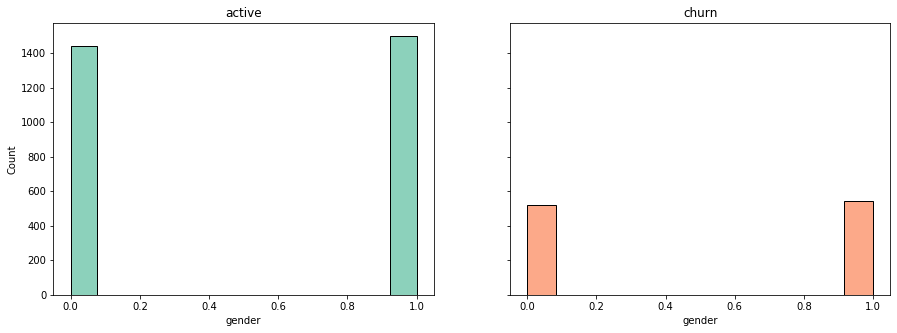

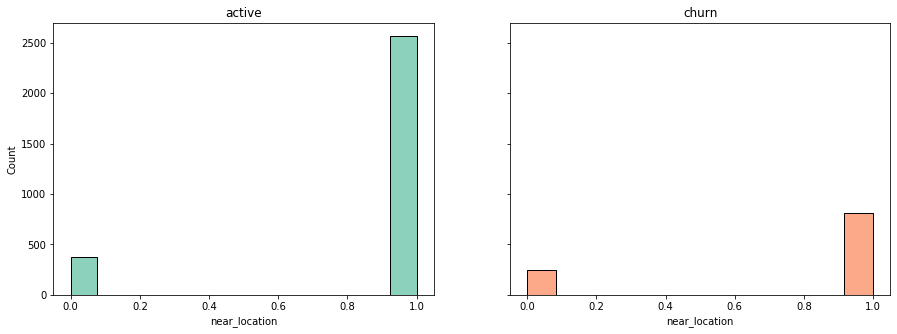

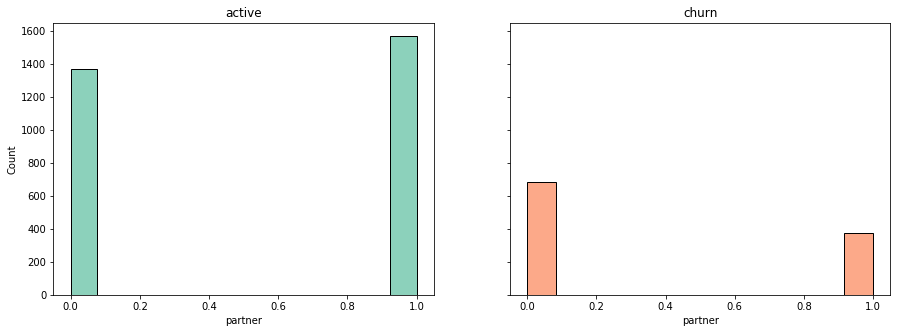

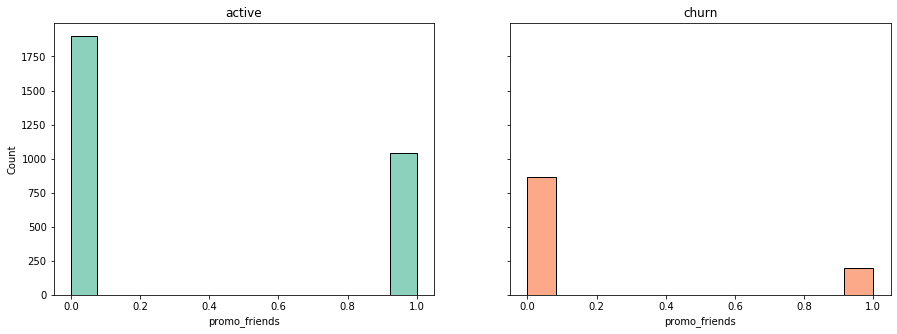

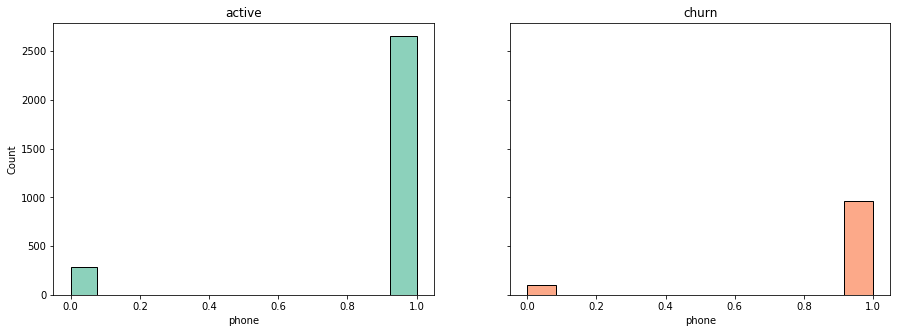

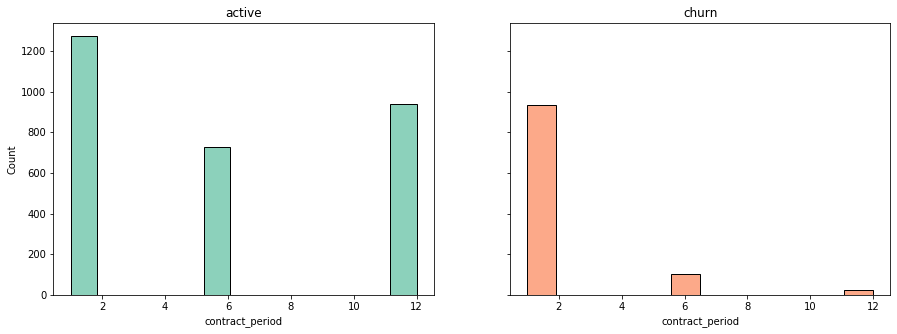

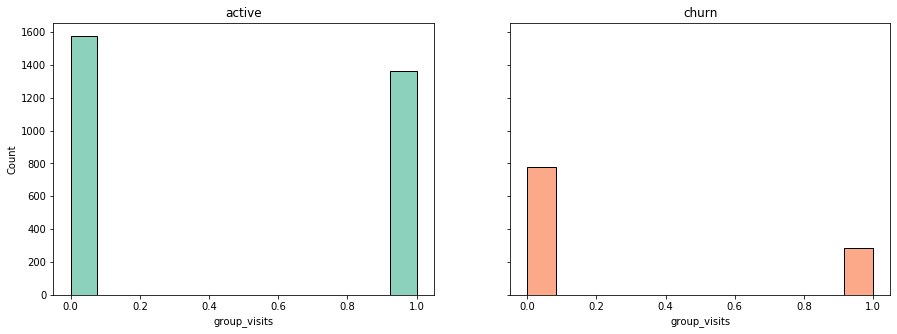

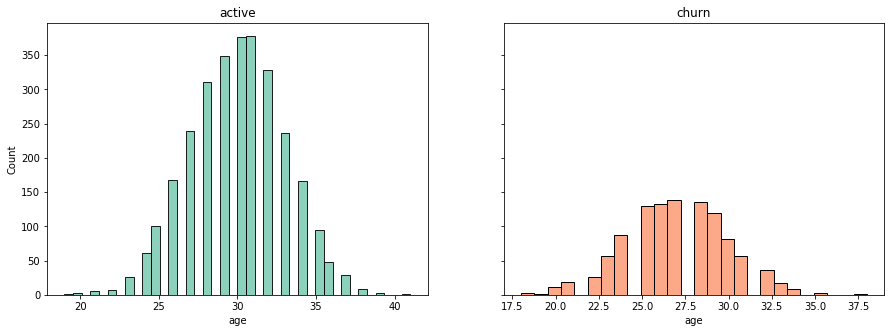

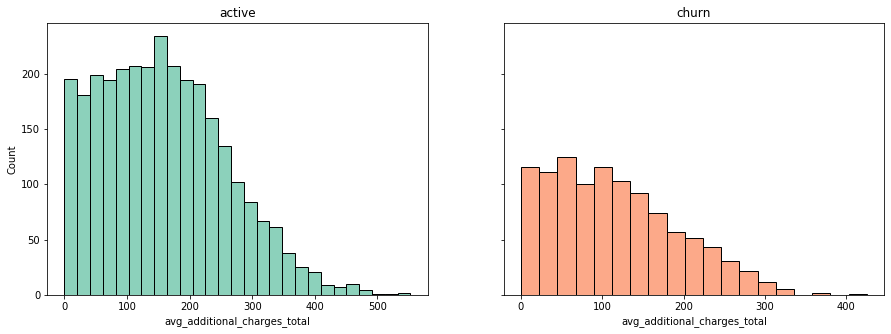

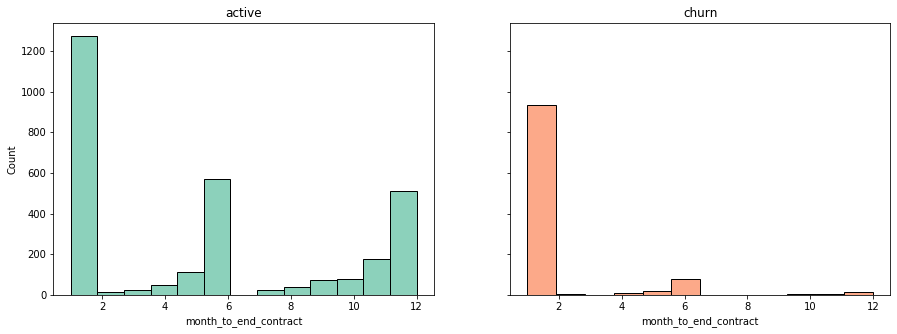

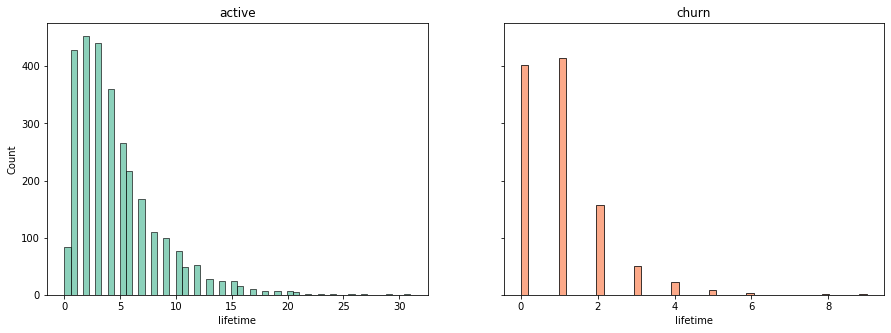

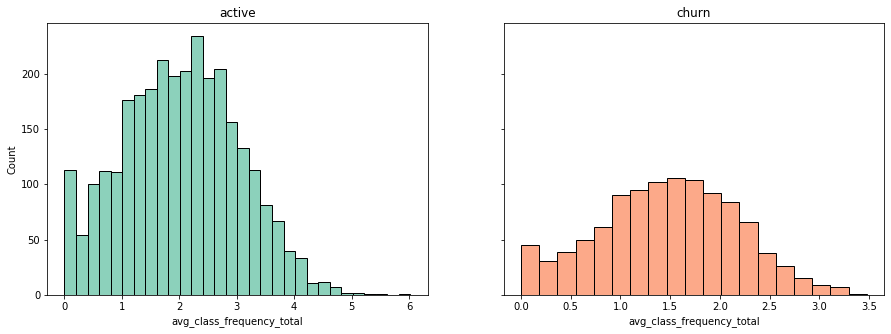

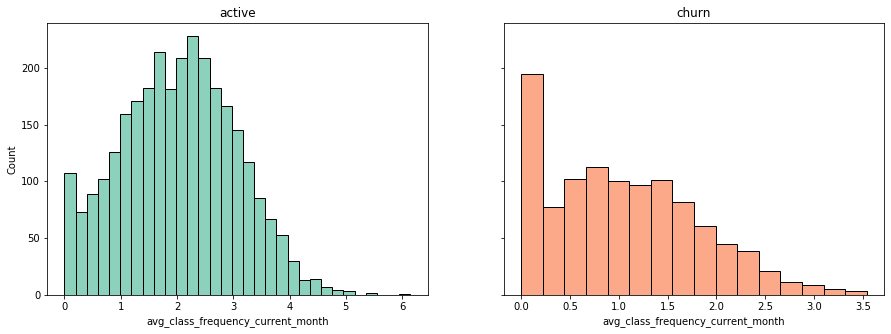

In [12]:
features = visitors.columns[:-1]
print('Абсолютные значения')
print_histplot(features)

Относительные значения (доли)


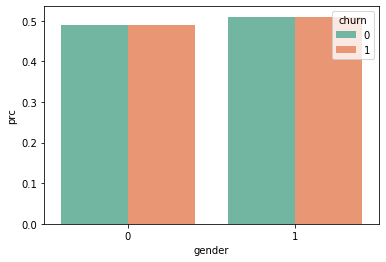

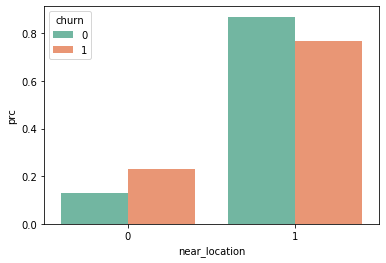

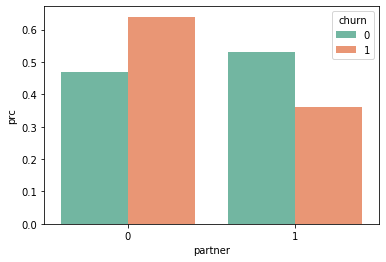

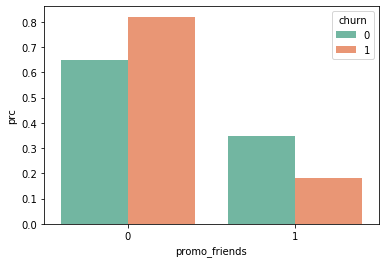

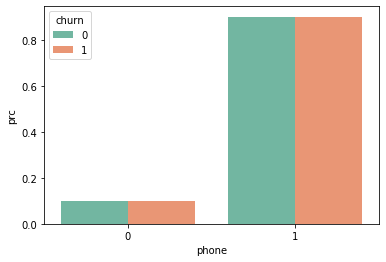

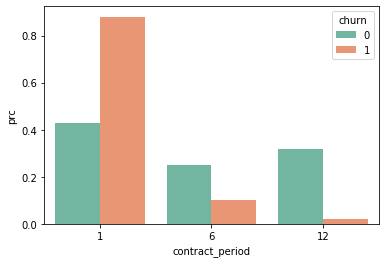

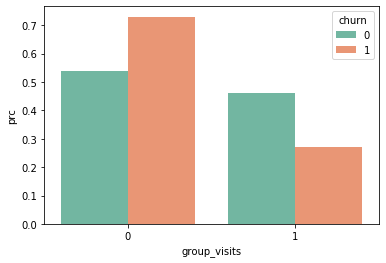

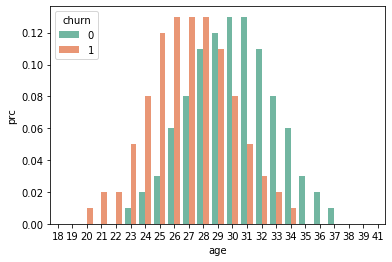

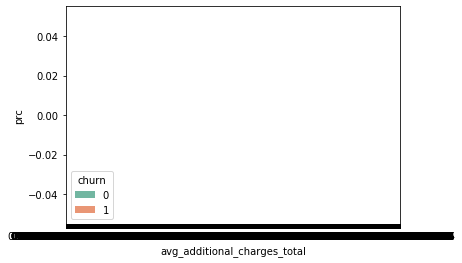

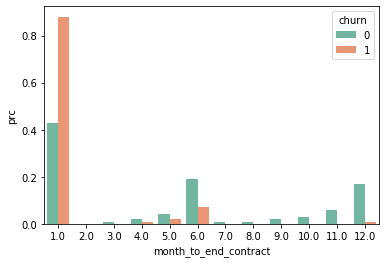

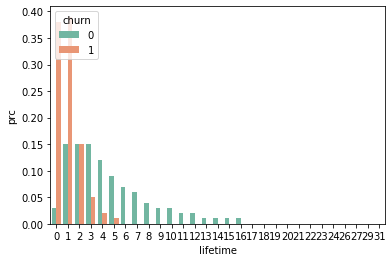

In [13]:
features = visitors.columns[:-3]
print('Относительные значения (доли)')
print_prc(features)

## Построим матрицу корреляций

Мы видим обратную корреляцию между оттоком и временем жизни клиента. Чем дольше клиент с нами,  нем ниже вероятность того, что он уйдет. А также обратная корреляциия между оттоком и колиичеством занятий в текущем месяце. Чем усерднее клиент занимается, тем ниже вероятность того,  что он уйдет.

Видна прямая связь между количеством месяцев до конца абонемента и длительностью самого абонемента - 
`contract_period` - `month_to_end_contract`.

Также заметна связь между средним количеством занятий за последний месяц и за все время абонемента - 
`avg_class_frequency_total` - `avg_class_frequency_current_month`.

Налиичиие среди характеристик нескольких параметров, которые напрямую коррелируют между собой, - не слишком хорошо для модели. При расчете модели удалим их из данных, оставив только один из показателей.

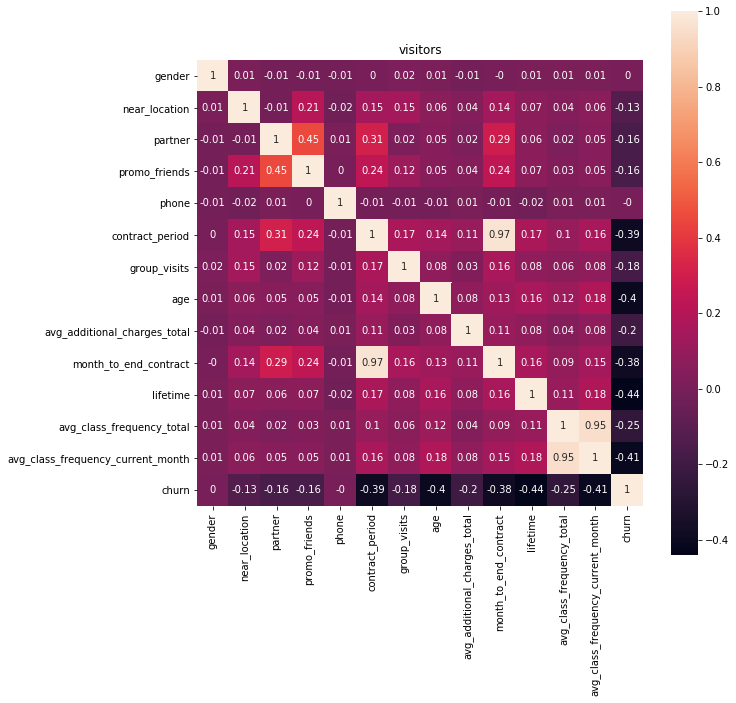

In [14]:
corr_visitors = visitors.corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('visitors')
sns.heatmap(data=corr_visitors.round(2), annot=True, square=True, ax=ax);
plt.show()

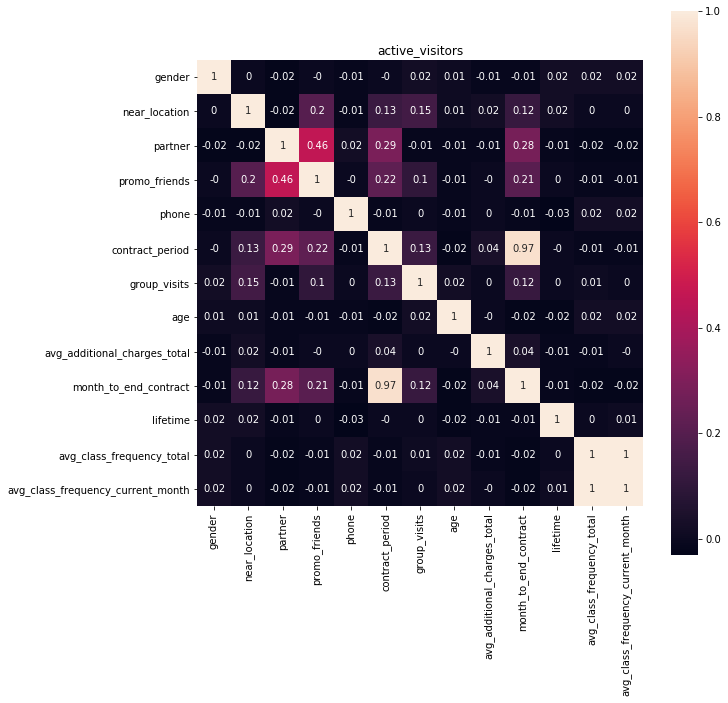

In [15]:
corr_active_visitors = active_visitors.drop('churn', axis=1).corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('active_visitors')
sns.heatmap(data=corr_active_visitors.round(2), annot=True, square=True, ax=ax);
plt.show()

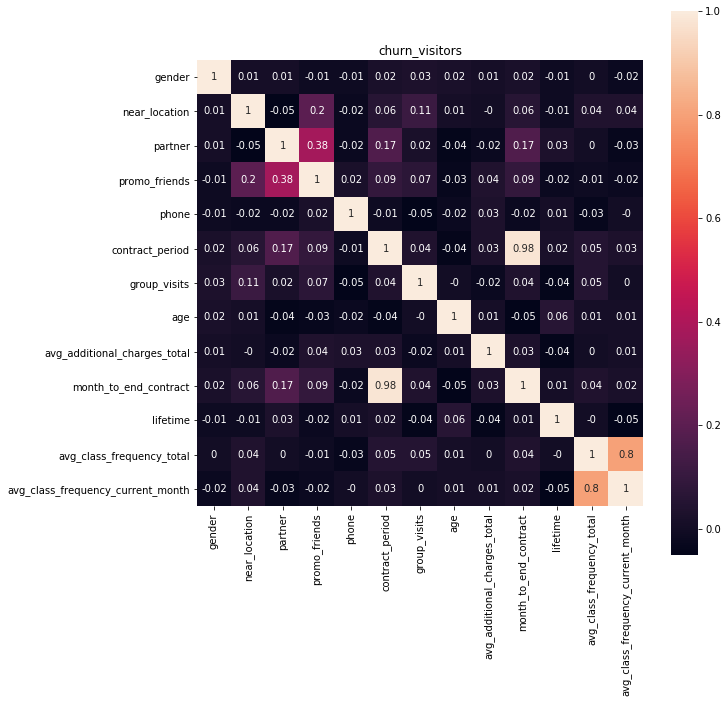

In [16]:
corr_churn_visitors = churn_visitors.drop('churn', axis=1).corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('churn_visitors')
sns.heatmap(data=corr_churn_visitors.round(2), annot=True, square=True, ax=ax);
plt.show()

# 3. Построим модель прогнозирования оттока клиентов

- [ ] Разобьем данные на обучающую и валидационную выборку функцией train_test_split().
- [ ] Обучим модель на train-выборке двумя способами:
    - логистической регрессией,
    - случайным лесом.
- [ ] Рассчитаем метрики accuracy, precision, recall, f1, roc_auc для обеих моделей на валидационной выборке. 
- [ ] Сравним модели на базе рассчитанных метрик.

## Разделим данные на признаки и целевую переменную. Целевой переменной является признак оттока `churn`.

In [26]:
X = visitors.drop(['churn', 'month_to_end_contract', 'avg_class_frequency_total'], axis=1)
y = visitors['churn']

## Разделим модель на обучающую и валидационную выборку в соотношени 80/20.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Стандартизируем данные

In [28]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

## Обучим модель на train выборке 
### - Логическая регрессия

In [29]:
logistic_regression_model = LogisticRegression(random_state=0)
logistic_regression_model.fit(X_train_st, y_train)
predictions_lrm = logistic_regression_model.predict(X_test_st)

### Выведем признаки и их веса в порядке убываниия абсолютных значений весов

In [30]:
features_lrm = pd.DataFrame(data={'features': X.columns,'coef': logistic_regression_model.coef_[0]})
features_lrm['abs'] = features_lrm['coef'].abs()

features_lrm.sort_values(by='abs', ascending=False)

,features,coef,abs
7,lifetime,-3.909556,3.909556
3,contract_period,-1.337473,1.337473
8,avg_class_frequency_current_month,-1.329162,1.329162
5,age,-1.098977,1.098977
6,avg_additional_charges_total,-0.581262,0.581262
4,group_visits,-0.378251,0.378251
2,promo_friends,-0.249448,0.249448
0,near_location,-0.081234,0.081234
1,partner,-0.063516,0.063516


Наибольший вес у параметра среднее колилчество занятий в текущем месяце,  на втором месте длительность жизненного цикла, на третьем местее среднее количество занятиий в целом за весь период. Первое и третье место очень связаны между собой.

### - Случайный лес

In [31]:
random_forest_classifier_model = RandomForestClassifier(random_state=0)
random_forest_classifier_model.fit(X_train_st, y_train)
predictions_rfc = random_forest_classifier_model.predict(X_test_st)

### Выведем признаки и их веса в порядке убываниия абсолютных значений весов

In [32]:
features_rfc = pd.DataFrame(data={'features': X.columns,'coef': random_forest_classifier_model.feature_importances_})
features_rfc['abs'] = features_rfc['coef'].abs()

features_rfc.sort_values(by='abs', ascending=False)

,features,coef,abs
7,lifetime,0.323377,0.323377
8,avg_class_frequency_current_month,0.227729,0.227729
5,age,0.137647,0.137647
6,avg_additional_charges_total,0.132131,0.132131
3,contract_period,0.115078,0.115078
4,group_visits,0.020090,0.020090
2,promo_friends,0.016023,0.016023
1,partner,0.015562,0.015562
0,near_location,0.012363,0.012363


## Рассчитаем метрики accuracy, precision, recall, f1, roc_auc для обеих моделей на валидационной выборке

In [33]:
def model_metrics(y_true, y_pred):
    metrics = []
    metrics.append(accuracy_score(y_true, y_pred))
    metrics.append(precision_score(y_true, y_pred))
    metrics.append(recall_score(y_true, y_pred))
    metrics.append(f1_score(y_true, y_pred))
    metrics.append(roc_auc_score(y_true, y_pred))
    return metrics

In [34]:
model_metrics = pd.DataFrame(data={'linear_regression_model': model_metrics(y_test, predictions_lrm), 
                                   'random_forest_classifier': model_metrics(y_test, predictions_rfc)}, 
                             index=['accuracy', 'precision', 'recall', 'f1', 'auc_roc'])

## Сравним модели на базе рассчитанных метрик.

In [35]:
model_metrics.style.highlight_max(color='#99ff99', axis=1)

,linear_regression_model,random_forest_classifier
accuracy,0.900000,0.888750
precision,0.789216,0.791444
recall,0.813131,0.747475
f1,0.800995,0.768831
auc_roc,0.870851,0.841345


<div style="background-color:#ff9977"> 
Добавить расчет для параметров без коррелирующих столбцов. Проверить метрикии и коэффициенты.
</div>

## ✴️ Показателии качества модели выше у модели рассчитанной при помощи линейной регрессии.

# Шаг 4. Сделайте кластеризацию клиентов
- [x] Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (клиентов):
- [x] Стандартизируйте данные.
- [ ] Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
- [ ] Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
- [ ] Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- [ ] Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
- [ ] Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [36]:
X_st = StandardScaler().fit_transform(X)

In [37]:
linked = linkage(X_st, method = 'ward') 

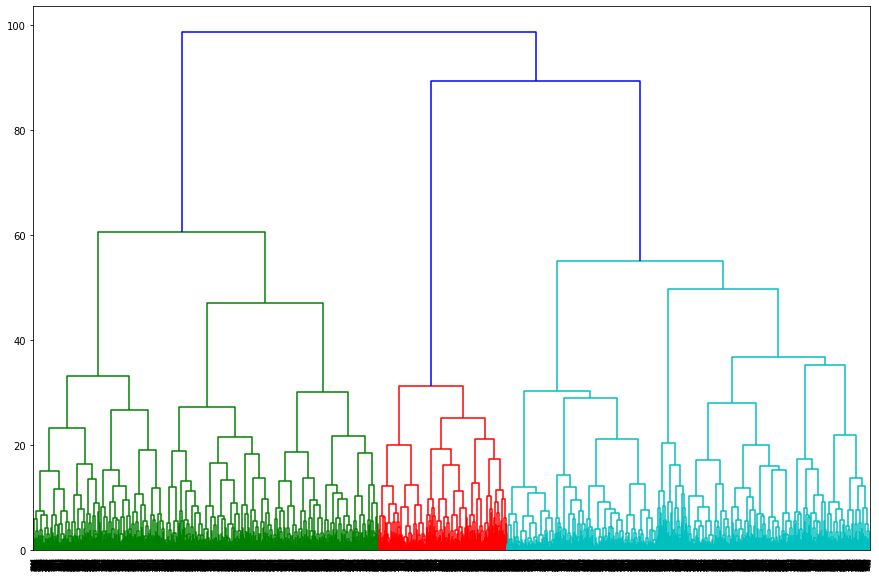

In [38]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Зададим модель k_means с числом кластеров 3

In [43]:
km = KMeans(n_clusters=3, random_state=0)

In [44]:
labels = km.fit_predict(X_st)

In [45]:
X['cluster_km'] = labels

In [46]:
X.groupby(by='cluster_km').mean()

,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month
cluster_km,,,,,,,,,
0,0.000000,0.489431,0.074797,3.045528,0.234146,28.713821,137.450020,3.068293,1.604212
1,1.000000,0.177146,0.061876,3.047405,0.393214,28.968563,142.322743,3.366267,1.694821
2,0.997104,0.934830,0.770456,7.780594,0.519189,29.706734,157.877171,4.537292,1.944384


In [25]:
#X.groupby(by='cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month
cluster_km,,,,,,,,,,,
0,0.490654,1.000000,0.217757,0.070093,1.0,2.042991,0.289720,27.671963,117.183090,1.945794,1.182417
1,0.495943,0.995943,0.891481,1.000000,1.0,6.911765,0.523327,29.601420,153.355426,4.281947,1.919083
2,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967
3,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146
4,0.546000,0.996000,0.380000,0.011000,1.0,6.209000,0.528000,30.629000,179.000022,5.414000,2.354146


# Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами
Сформулируйте основные выводы и предложите рекомендации для стратегии взаимодействия с клиентами и их удержания.
Не описывайте стратегию детально: достаточно 3-4 важных принципов и примеров их реализации в виде определённых маркетинговых действий.

In [103]:
%%time
features = visitors.drop('churn', axis=1).columns
features

CPU times: user 1.23 ms, sys: 203 µs, total: 1.43 ms
Wall time: 1.42 ms


Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month'],
      dtype='object')

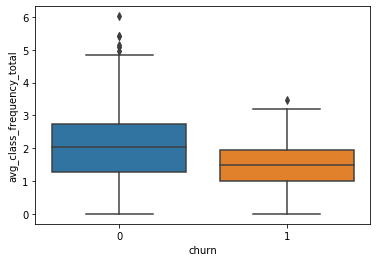

CPU times: user 472 ms, sys: 93.3 ms, total: 565 ms
Wall time: 626 ms


In [110]:
%%time
for feature in ['avg_class_frequency_total']:
    '''
    print(feature)
    new = visitors.groupby(by=['churn', feature])\
    .agg({feature: 'count'})\
    .rename(columns={feature: 'abs'})\
    .reset_index()

    new['prc'] = new.apply(lambda x: (x['abs']/(new[new['churn'] == x['churn']]['abs'].sum()))\
                           .round(2), 
                           axis=1)
    '''
    if feature.find('avg_') == 0:
        sns.boxplot(x='churn', y=feature, data=visitors)
        plt.show()

In [105]:
new

,churn,avg_additional_charges_total,abs,prc
0,0,0.171862,1,0.0
1,0,0.251606,1,0.0
2,0,0.362153,1,0.0
3,0,0.428233,1,0.0
4,0,0.434087,1,0.0
...,...,...,...,...
3995,1,330.142259,1,0.0
3996,1,334.140355,1,0.0
3997,1,372.059914,1,0.0
3998,1,374.089066,1,0.0


In [88]:
sum_tab = new.groupby(by=['churn']).agg({'abs': 'sum'}).rename(columns={'abs': 'prc'})

In [89]:
new = new.merge(right=sum_tab, on='churn', how='left')
new['prc'] = new['abs']/new['prc']

In [90]:
new

,churn,gender,abs,prc_x,prc_y,prc
0,0,0,1440,2939,2939,0.489963
1,0,1,1499,2939,2939,0.510037
2,1,0,519,1061,1061,0.489161
3,1,1,542,1061,1061,0.510839


In [95]:
%%time
for feature in features[0:1]:
    print(feature)
    new = visitors.groupby(by=['churn', feature]).agg({feature: 'count'})
    new = new.rename(columns={feature: 'abs'})
    new = new.reset_index()

    new = new.merge(right=new.groupby(by=['churn']).agg({'abs': 'sum'}).rename(columns={'abs': 'prc'}), 
                    on='churn', 
                    how='left')
    new['prc'] = (new['abs']/new['prc']).round(2)

gender
CPU times: user 10.9 ms, sys: 696 µs, total: 11.6 ms
Wall time: 11.4 ms


In [96]:
new

,churn,gender,abs,prc
0,0,0,1440,0.49
1,0,1,1499,0.51
2,1,0,519,0.49
3,1,1,542,0.51
